In [2]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [3]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='iserc-1', project='main')

In [4]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [5]:
from qiskit import *

In [6]:
from matplotlib import pyplot as plt

In [148]:
# backend = provider.get_backend('ibmq_armonk')
backend = provider.get_backend('ibmq_casablanca')

### Step 1: Implementing the frequency sweep experiment to determine the qubit frequency

In [149]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor

qubit = 0
back_config = backend.configuration()
inst_sched_map = backend.defaults().instruction_schedule_map
meas_map_idx = None
for i, measure_group in enumerate(back_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
measure = inst_sched_map.get('measure', qubits=back_config.meas_map[qubit])

pulse_sigma = 40
pulse_duration = (4*pulse_sigma)-((4*pulse_sigma)%16)
drive_chan = DriveChannel(0)

def create_cal_circuits(amp):
    sched = Schedule()
    sched+=Play(Gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=amp), drive_chan)
    measure = inst_sched_map.get('measure', qubits=[qubit])
    sched+=measure << sched.duration
    return sched

default_qubit_freq = backend.defaults().qubit_freq_est[0]
freq_list = np.linspace(default_qubit_freq-(20*1e+6), default_qubit_freq+(20*1e+6), 75)
sched_list = [create_cal_circuits(0.4)]*75
# sweep_exp = assemble(sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los = [{drive_chan: freq} for freq in freq_list])
# sweep_job = backend.run(sweep_exp)
sweep_job = execute(sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los = [{drive_chan: freq} for freq in freq_list])
job_monitor(sweep_job)
sweep_result = sweep_job.result()
sweep_values = []
for i in range(len(sweep_result.results)):
    res = sweep_result.get_memory(i)*1e-14
    sweep_values.append(res[qubit])
scale_factor = 1e+9
freq_list_scaled = freq_list/scale_factor

Job Status: job has successfully run


In [152]:
from scipy.optimize import curve_fit

def find_init_params(res_values):
    est_baseline = np.mean(res_values)
    est_slope = -5 if est_baseline-np.min(res_values) > 2 else 5
    return [est_slope, 4.975, 1, est_baseline]

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

init_params = find_init_params(np.real(sweep_values)) # initial parameters for curve_fit
# init_params = [5, ]
fit_params, y_fit = fit_function(freq_list_scaled,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 init_params
                                )

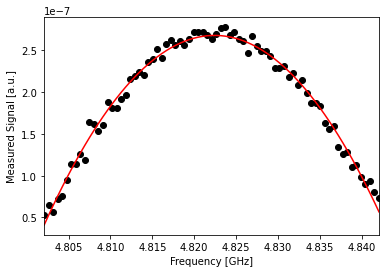

In [155]:
plt.scatter(freq_list_scaled, np.real(sweep_values), color='black')
plt.plot(freq_list_scaled, y_fit, color='red')
plt.xlim([min(freq_list_scaled), max(freq_list_scaled)])
# plt.ylim([-7,0])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

_, qubit_freq_new, _, _ = fit_params
qubit_freq_ground = qubit_freq_new*scale_factor

In [150]:
speak("The test program is done.")

In [156]:
print(f"The new qubit frequency is : {qubit_freq_ground} Hz")

The new qubit frequency is : 4822436345.493588 Hz


### Step 2: Implementing the Rabi experiment to determine the pi amp for 0->1 transition

In [157]:
#### Moving on to the Rabi experiments for 0->1 transition.

amp_list = np.linspace(0, 1.0, 75)
rabi_sched_list = [create_cal_circuits(amp) for amp in amp_list]
# rabi_exp = assemble(rabi_sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}]*len(rabi_sched_list))
# rabi_job = backend.run(rabi_exp)
rabi_job = execute(rabi_sched_list, backend=backend, meas_level=1, meas_return='avg', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}]*len(rabi_sched_list))
job_monitor(rabi_job)
rabi_results = rabi_job.result()
scale_factor = 1e-14
rabi_values = []
for i in range(75):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

def baseline_remove(values):
    return np.array(values) - np.mean(values)

rabi_values = np.real(baseline_remove(rabi_values))

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Job Status: job has successfully run


In [180]:
fit_params, y_fit = fit_function(amp_list,
                             rabi_values, 
                             lambda x, A, B, drive_period, phi: (A*np.sin(2*np.pi*x/drive_period - phi) + B),
                             [3*1e-7, 0, 0.3, 0])
drive_period = fit_params[2]
pi_amp_ground = drive_period/2

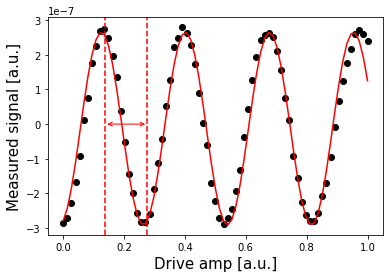

In [186]:
plt.scatter(amp_list, rabi_values, color='black')
plt.plot(amp_list, y_fit, color='red')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
# plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [187]:
print(f"The calibrated pi amp is : {pi_amp_ground}")

The calibrated pi amp is : 0.1380650988606908


In [17]:
speak("The test program is over. Have a look at it.")

### Step 3: Implementing zero and one sched by executing them together using execute function

In [223]:
from qiskit.pulse import library as pulse_lib

def get_pi_pulse_ground():
    pulse = pulse_lib.gaussian(duration=pulse_duration, sigma=pulse_sigma, amp=pi_amp_ground)
    return pulse

def get_zero_sched():
    zero_sched = Schedule()
    zero_sched += measure
    return zero_sched

def get_one_sched():
    one_sched = Schedule()
    one_sched += Play(get_pi_pulse_ground(), drive_chan)
    one_sched += measure << one_sched.duration
    return one_sched

def IQ_plot(zero_data, one_data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    x_min = np.min(np.append(np.real(zero_data), np.real(one_data)))-5
    x_max = np.max(np.append(np.real(zero_data), np.real(one_data)))+5
    y_min = np.min(np.append(np.imag(zero_data), np.imag(one_data)))-5
    y_max = np.max(np.append(np.imag(zero_data), np.imag(one_data)))+5

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=50, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=50, cmap='viridis', c='black',alpha=1.0)

#     plt.xlim(x_min, x_max)
#     plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)
    return x_min, x_max, y_min, y_max

In [189]:
def get_job_data(job, average):
    scale_factor = 1e-14
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

In [190]:
discrim_01_sched_list = [get_zero_sched(), get_one_sched()]
discrim_job = execute(discrim_01_sched_list, backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}]*2)
job_monitor(discrim_job)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Job Status: job has successfully run


In [191]:
discrim_data = get_job_data(discrim_job, average=False)
zero_data = discrim_data[0]
one_data = discrim_data[1]

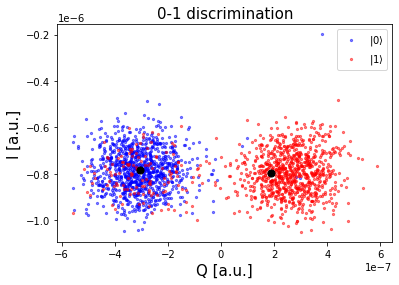

In [224]:
x_min, x_max, y_min, y_max = IQ_plot(zero_data, one_data)

### Step 4: Implementing zero sched and one sched by implementing them separately using execute function

In [226]:
discrim_job_0 = execute(get_zero_sched(), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
# discrim_job_0 = execute(zero_pulse_with_gap(350), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
job_monitor(discrim_job_0)
discrim_job_1 = execute(get_one_sched(), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
job_monitor(discrim_job_1)

Job Status: job has successfully run
Job Status: job has successfully run


In [227]:
zero_data_sep = get_job_data(discrim_job_0, average=False)
one_data_sep = get_job_data(discrim_job_1, average=False)

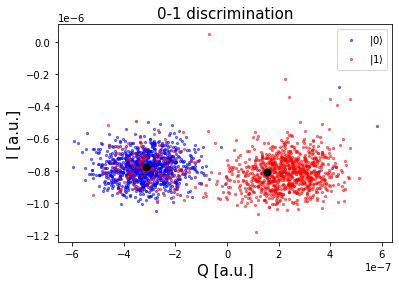

In [228]:
x_min, x_max, y_min, y_max = IQ_plot(zero_data_sep, one_data_sep)

### Step 5: Implementing the zero and one schedule together by using assemble function

In [26]:
discrim_01_sched_list_assemble = [get_zero_sched(), get_one_sched()]
discrim_exp = assemble(discrim_01_sched_list_assemble, backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}]*2)
discrim_job_assemble = backend.run(discrim_exp)
job_monitor(discrim_job_assemble)

/home/tharrma/research_qiskit/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Job Status: job has successfully run


In [27]:
discrim_data_assemble = get_job_data(discrim_job_assemble, average=False)
zero_data_asmbl = discrim_data_assemble[0]
one_data_asmbl = discrim_data_assemble[1]

In [ ]:
x_min, x_max, y_min, y_max = IQ_plot(zero_data_asmbl, one_data_asmbl)

### Step 6: Implementing the zero and the one scheds separately using assemble function

In [29]:
discrim_exp_0 = assemble(get_zero_sched(), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
discrim_job_0_asmbl = backend.run(discrim_exp_0)
job_monitor(discrim_job_0_asmbl)
discrim_exp_1 = assemble(get_one_sched(), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
discrim_job_1_asmbl = backend.run(discrim_exp_1)
job_monitor(discrim_job_1_asmbl)

Job Status: job has successfully run
Job Status: job has successfully run


In [30]:
zero_data_sep_asmbl = get_job_data(discrim_job_0_asmbl, average=False)
one_data_sep_asmbl = get_job_data(discrim_job_1_asmbl, average=False)

In [ ]:
x_min, x_max, y_min, y_max = IQ_plot(zero_data_sep_asmbl, one_data_sep_asmbl)

### Step 7: Implementing the zero schedules with various initial idle time separately

In [229]:
def zero_pulse_with_gap(gap):
    gapped_sched = Schedule()
    gapped_sched += measure << gap
    return gapped_sched

In [230]:
gap_list = range(0,720,100)
gap_sched_list = [zero_pulse_with_gap(gap) for gap in gap_list]

In [297]:
print('Gap list : ', [*gap_list])

Gap list :  [0, 100, 200, 300, 400, 500, 600, 700]


In [231]:
out_file = open("temp_01_scheds_sep_result_casablanca.txt", "w")
for idx, sched in enumerate(gap_sched_list):
    gap_job = execute(sched, backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
    if idx%1==0:
        print("Running job number %d" % idx)
    job_monitor(gap_job)
    gap_data = get_job_data(gap_job, average=False)
    print('0', idx*10, gap_data[0].tolist(), file=out_file)
gap_job = execute(get_one_sched(), backend=backend, meas_level=1, meas_return='single', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
job_monitor(gap_job)
gap_data = get_job_data(gap_job, average=False)
print('1', '0', gap_data[0].tolist(), file=out_file)
out_file.close()

Running job number 0
Job Status: job has successfully run
Running job number 1
Job Status: job has successfully run
Running job number 2
Job Status: job has successfully run
Running job number 3
Job Status: job has successfully run
Running job number 4
Job Status: job has successfully run
Running job number 5
Job Status: job has successfully run
Running job number 6
Job Status: job has successfully run
Running job number 7
Job Status: job has successfully run
Job Status: job has successfully run


In [280]:
import ast
res_file = open("temp_01_scheds_sep_result_casablanca.txt",'r')
res_array =[]
res = res_file.readline()
iter=1
while res:
    res_array.append(ast.literal_eval(res[res.find('['):]))
    res = res_file.readline()
    iter += 1
res_file.close()

9


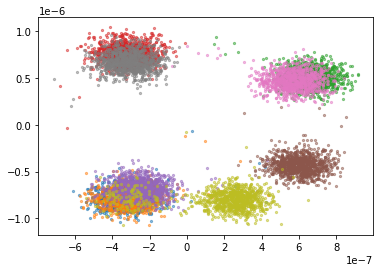

In [291]:
plt.figure()
print(len(res_array))
for idx, dat in enumerate(res_array[:9]):
    plt.scatter(np.real(dat), np.imag(dat), s=5, alpha=0.5)
plt.show()

### Step 8: Implementing zero scheds with various idle times separately with meas_level=2

In [292]:
for idx, sched in enumerate(gap_sched_list):
    gap_job = execute(sched, backend=backend, meas_level=2, meas_return='avg', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
    if idx%1==0:
        print("Running job number %d" % idx)
    job_monitor(gap_job)
    result_counts = gap_job.result().get_counts()
    print('0 : ','Gap : ', idx*10, result_counts)
gap_job = execute(get_one_sched(), backend=backend, meas_level=2, meas_return='avg', shots=1024, schedule_los=[{drive_chan: qubit_freq_ground}])
job_monitor(gap_job)
result_counts = gap_job.result().get_counts()
print('1 : ','Gap : 0', result_counts)

Running job number 0
Job Status: job has successfully run
0 :  Gap :  0 {'0000000': 951, '0000001': 7, '0010000': 5, '0000010': 27, '0100000': 8, '0000100': 7, '1000000': 12, '0000110': 1, '0001000': 6}
Running job number 1
Job Status: job has successfully run
0 :  Gap :  10 {'0000000': 962, '0000001': 5, '0010000': 3, '0000010': 26, '0100000': 2, '0000100': 6, '1000000': 10, '0001000': 10}
Running job number 2
Job Status: job has successfully run
0 :  Gap :  20 {'0111001': 7, '0111101': 997, '0111111': 3, '1111101': 17}
Running job number 3
Job Status: job has successfully run
0 :  Gap :  30 {'0100000': 5, '0101000': 1008, '0101010': 4, '1101000': 7}
Running job number 4
Job Status: job has successfully run
0 :  Gap :  40 {'0000000': 910, '0000001': 8, '0010000': 3, '0010010': 1, '0000010': 52, '0100000': 3, '0000100': 18, '1000000': 9, '1001010': 1, '0000110': 2, '1100000': 1, '0001000': 11, '0001001': 1, '0001010': 3, '0001100': 1}
Running job number 5
Job Status: job has successful

In [42]:
speak("The complete program is over. Check it out.")